# Scientific Computing: Assignment Set 1
_Boyan Mihaylov (15067602)_

## 0. Imports / Preliminaries

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import f_oneway
from importlib import reload

Two external Python modules are loaded: one for the DLA model and one for the Gray-Scott reaction-diffusion model.

In [2]:
import dla as dla
import gray_scott as gs
import vis_tools as vis

## 1. DLA (Time-Independent Diffusion Equation)

The first DLA implementation builds up on the time-independent diffusion model developed in the previous exercise set. First, potential growth candidates are defined as all non-occupied neighbours of the existing sites in the DLA cluster. In the initial state, the cluster consists of a single seed positioned in the middle of the bottom row of a lattice of size $N\times N$. The concentration values on the lattice inform the selection probabilities of all growth candidates, following the equation:

$$
p_g(i,j) = \frac{c_{i,j}^\eta}{\sum_{\textrm{growth candidates}}c_{i,j}^\eta}.
$$

Here $i\in[0,N]$ and $j\in[0,N]$ are integer indices of the lattice sites and $\eta$ is a characteristic parameter influencing the compactness of the resulting cluster. While the diffusion process conciders periodicity of the lattice in the $x$-dimension, the growth process is not periodic and does not consider any neighbours beyond the left and the right lattice boundaries.

Starting from a linear concentration gradient between the top and the bottom row ($c(x,y)=y$), the concentration values are updated by a diffusion loop after each growth step of the DLA cluster, taking into account sites from the cluster as sinks in the diffusion. The top row of the lattice is thereby considered a constant source ($c_{i, N}=1$) and the bottom row a constant sink ($c_{i, 0}=0$). The concentrations converge to a steady-state solution following a Successive Over-Relaxation (SOR) update scheme with a specific relaxation factor $\omega$. The SOR algorithm can either run in a sequential mode or employ GPU paralellisation using _Numba_'s CUDA interface. In the second case, a Red-Black checkerboard scheme is used to separate the lattice array in two interlaced, alternatingly updated sub-arrays.

### 1.1. Model Test

Below is a single growth realisation of a DLA cluster with $5000$ sites on a $500\times500$ lattice, using parameters $\eta=1$ and $\omega=1.9$.

In [159]:
reload(dla)
reload(vis)

<module 'vis_tools' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 2\\vis_tools.py'>

In [161]:
# Simulation parameters
size = 500
max_iter = 5000
omega = 1.9
eta = 1

c_grid, cluster_grid, _ = dla.run_dla_diff_equation(size, 5000, omega, eta, GPU_delta_interval=50)

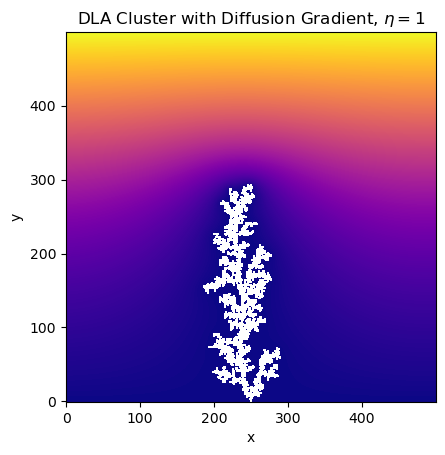

In [162]:
vis.plot_dla(cluster_grid, c_grid, title=f"DLA Cluster with Diffusion Gradient, $\eta={eta}$")

### 1.2. Study of the $\eta$ and $\omega$ Parameters

Previous studies have indicated an optimal relaxation factor $\omega\approx1.97$ for a lattice size of $N=128$ and a setup with equivalent source and sink boundary conditions but no objects occupying the lattice. With a DLA cluster present, the $\eta$ exponent impacts its shape as it grows. A relevant question is if and how the resulting cluster shapes affect the optimal $\omega$.

To study this, multiple DLA realisations are simulated for different $\eta$ parameter values on a lattice of size $N=100$, halting at a cluster size of $S=200$. Each realisation is first run through a Brent minimisation algorithm (the `minimize_scalar` function of the `scipi.optimize` module) in order to find the optimal $\omega$ value for the current configuration. A random seed is used to guarantee that the resulting shape is always the same during the optimisation process. To quantify the shape characteristics of the current shape, its fractal dimension is measured by tracing the distance of each cluster site to the original seed and assuming circular regions with radii equal to these distances. For each radius $r$, the mass $M(r)$ of the cluster (equivalent to the number of occupied sites) within the circle is computed. The fractal dimension $D_r$ thereby obeys the relationship:

$$
M(r)=r^{D_r}
$$

and can be computed by performing linear regression through the log-log plot of the radii and their corresponding masses.

To speed up the computation, the parallelised variant of the algorithm is used, with a convergence check happening every 20 iterations. This has an effect that the maximum iteration counts towards which $\omega$ is optimised are always multiples of 20.

The results from each realisation are saved in a `DataFrame` object for future analysis.

In [262]:
# Simulation constants
size = 100
target_mass = 200
n_sims = 30

# Parameter range
eta_range = np.linspace(0, 2, 11)

df_sim_results, c_grids, cluster_grids = dla.run_dla_eta(size, target_mass, eta_range, n_sims, GPU_delta_interval=20)

Running parameter eta = 0.0
Running simulation 1/330


c:\Users\mihbo\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:538: NumbaPerformanceWarning: Grid size 28 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Running simulation 2/330
Running simulation 3/330
Running simulation 4/330
Running simulation 5/330
Running simulation 6/330
Running simulation 7/330
Running simulation 8/330
Running simulation 9/330
Running simulation 10/330
Running simulation 11/330
Running simulation 12/330
Running simulation 13/330
Running simulation 14/330
Running simulation 15/330
Running simulation 16/330
Running simulation 17/330
Running simulation 18/330
Running simulation 19/330
Running simulation 20/330
Running simulation 21/330
Running simulation 22/330
Running simulation 23/330
Running simulation 24/330
Running simulation 25/330
Running simulation 26/330
Running simulation 27/330
Running simulation 28/330
Running simulation 29/330
Running simulation 30/330
Running parameter eta = 0.2
Running simulation 31/330
Running simulation 32/330
Running simulation 33/330
Running simulation 34/330
Running simulation 35/330
Running simulation 36/330
Running simulation 37/330
Running simulation 38/330
Running simulation

The simulation results can be saved for later use.

In [263]:
df_sim_results.to_csv("dla_diffusion_results.csv")
np.save("dla_diffusion_c_grids.npy", c_grids)
np.save("dla_diffusion_cluster_grids.npy", cluster_grids)

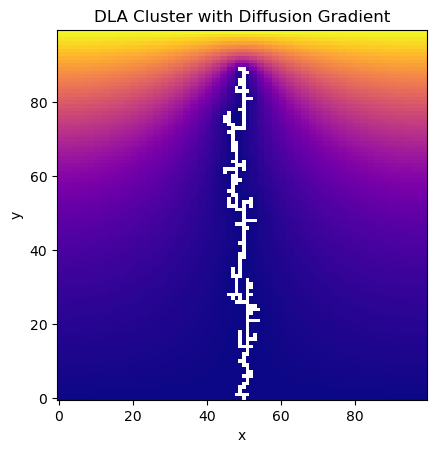

In [46]:
ind_a = 2
ind_b = 0
vis.plot_dla(cluster_grids[ind_a][ind_b], c_grids[ind_a][ind_b])

In the analysis of the results, the influence of $\eta$ over the optimal $\omega$ and the fractal dimension $D_r$ is examined through plots showing the mean values and a 95% confidence interval.

# CHECK NORMALITY

In [264]:
df_sim_results = pd.read_csv("dla_diffusion_results.csv")
c_grids = np.load("dla_diffusion_c_grids.npy")
cluster_grids = np.load("dla_diffusion_cluster_grids.npy")

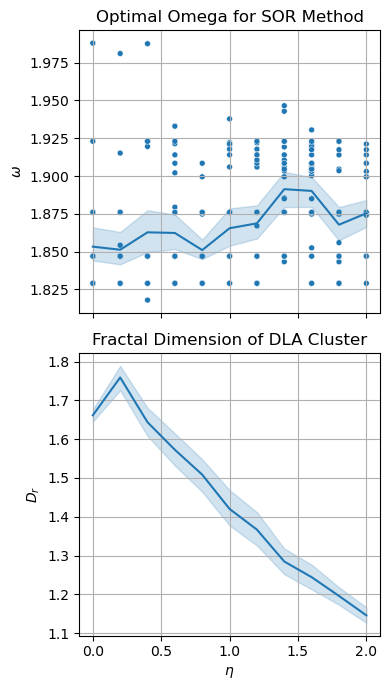

In [265]:
vis.plot_dla_diff_sim_params(df_sim_results)

Even though the first plot indicates a rising trend for the optimal $\omega$ value with increasing $\eta$, this trend is not straightforward and exhibits high variance. Therefore, a statistical test is needed to verify the validity of any claims about the interdependence of the two parameters. A one-way ANOVA is performed on the factor $\eta$ to test the null-hypothesis that the factor has no influence on the response variable $\omega$. For this, the values of $\eta$ are grouped by their corresponding $\omega$ levels.

In [266]:
eta_unique = df_sim_results['$\eta$'].unique()
eta_omegas = [df_sim_results[df_sim_results['$\eta$'] == eta]['$\omega$'].values for eta in eta_unique]
f_stat, p_val = f_oneway(*eta_omegas)

print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.2f}")

ANOVA F-statistic: 5.85, p-value: 0.00


The resulting p-value shows a high significance of the effect of $\eta$ on the mean optimal $\omega$, which fluctuates between approximately 1.85 and 1.875 for $\eta<1$ and between approximately 1.875 and 1.9 for $\eta\ge1$. Furthermore, an examination of the overlaid scatter plot indicates that for $\eta<0.5$ the distribution of optimal $\omega$ values occasionally encompasses higher values, whereas for higher $\eta$ there seems to be a saturation of values below a threshold and no measurements above it - signalling that these are critical thresholds beyond which the simulation explodes into instability, as observations have shown in previous studies.

The second plot indicates a clear trend of reduction of the fractal dimension from approximately 1.8 to just below 1.2 with increasing $\eta$. This is to be expected, since the compact clusters generated with low $\eta$ are closer to a solid shape with a fractal dimension equal to its topological one, whereas high $\eta$ clusters become increasingly linear, their fractal dimension being reduced closer to unity. These effects can be clearly observed by visualising single results from different $\eta$ configuraions:

# ADD COLOR BAR!

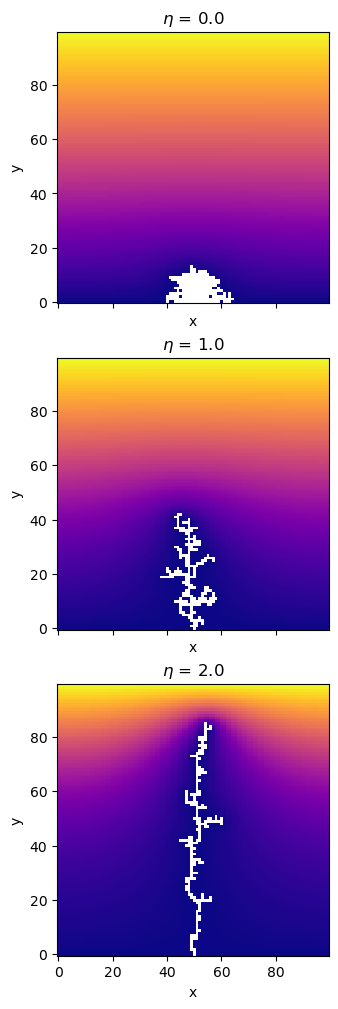

In [267]:
etas_plot = [0.0, 1.0, 2.0]

# Get index of first simulations in DataFrame for each eta
eta_indices = [df_sim_results[df_sim_results['$\eta$'] == eta].index[0] for eta in etas_plot]
c_grids_plot = c_grids.reshape(-1, c_grids.shape[-2], c_grids.shape[-1])[eta_indices]
cluster_grids_plot = cluster_grids.reshape(-1, cluster_grids.shape[-2], cluster_grids.shape[-1])[eta_indices]

vis.plot_dla_param_snapshots(cluster_grids_plot, etas_plot, c_grids_plot, param_name="$\eta$")

## 2. DLA (Random Walkers)

The second DLA implementation is driven by a diffusion principle based on a more direct interpretation of Brownian motion. As part of each growth step, an unbiased random walker is released at a random position in the top (source) row of the lattice. Growth candidates of the cluster are defined in the same way as in the previous DLA algorithm. Once the walker enters the site of a growth candidate, it attaches to the cluster with a probability $p_s$. The periodic side boundaries also apply for this case: the random walk may wrap around the domain in the $x$-direction. Upon attachment or crossing of the top or bottom boundary, the walker is regenerated at a random top position. If the attachment is unsuccessful, the walk continues to any unoccupied neighbour site.

### 2.1. Model Test

The stochastic search performed by the random walkers can be computationally inefficient if performed sequentially, especially with large lattice sizes. To reduce the simulation time, the algorithm is set up using a mixture of sequential loops and vectorised _NumPy_ operations. Within a single sequential step, $N$ random walker trajectories of length $N$ are computed as _NumPy_ arrays and, if any one of them includes a position adjacent to the cluster (1), accepted with probability $p_s$ (2) and not occurring after passing beyond the top/bottom boundaries (3) or into the cluster (4), the trajectory is pre-selected. From this selection of successful trajectories, one is picked at random, the position on it complying with the above criteria is added to the cluster and the walkers are reset for the next sequential step. If none of the conditions 1-4 were satisfied, a collection of residual walkers is stored for the next step, consisting of all positions prior to collision with the cluster but not after exit and re-entry through the top/bottom boundaries. Since no successful attachment has happened, it is implied that these are growth candidate positions that did not pass the probabilistic test before they collided with the cluster. This way they are allowed another chance to continue on an alternative path in the next sequential iteration. Each subsequent iteration therefore starts with either a completely new set of random walkers or with a mix between re-initialised walkers and residual ones from the previous iteration.

In [131]:
reload(dla)

<module 'dla' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 2\\dla.py'>

In [132]:
# Simulation parameters
size = 100
max_iter = 200

cluster_grid = dla.run_dla_monte_carlo(size, max_iter, p_s=0.5)

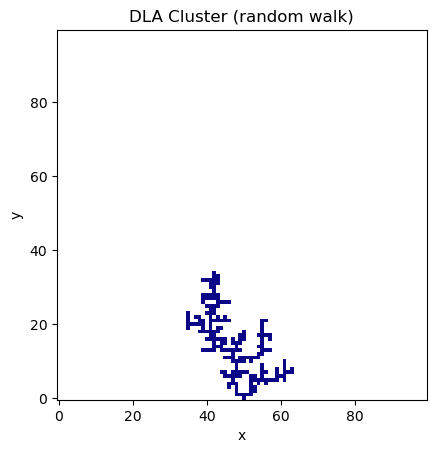

In [133]:
vis.plot_dla(cluster_grid, title="DLA Cluster (random walk)")

### 2.2. Effect of $p_s$

To perform a morphological study comparable with the previous DLA model, the fractal dimension of the Monte Carlo DLA cluster is examined, this time in relation to the probability $p_s$. A range of values of $p_s$ between $0.05$ and $1.0$ is iterated through, once again with 30 simulations per parameter, with the fractal dimension being measured and recorded in a `DataFrame` object.

In [93]:
reload(dla)

<module 'dla' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 2\\dla.py'>

In [94]:
# Simulation constants
size = 100
target_mass = 200
n_sims = 30

# Parameter range
p_s_range = np.linspace(0.05, 1, 11)

df_sim_results, cluster_grids = dla.run_dla_p_s(size, target_mass, p_s_range, n_sims)

Running parameter p_s = 0.05
Running simulation 1/330
Running simulation 2/330
Running simulation 3/330
Running simulation 4/330
Running simulation 5/330
Running simulation 6/330
Running simulation 7/330
Running simulation 8/330
Running simulation 9/330
Running simulation 10/330
Running simulation 11/330
Running simulation 12/330
Running simulation 13/330
Running simulation 14/330
Running simulation 15/330
Running simulation 16/330
Running simulation 17/330
Running simulation 18/330
Running simulation 19/330
Running simulation 20/330
Running simulation 21/330
Running simulation 22/330
Running simulation 23/330
Running simulation 24/330
Running simulation 25/330
Running simulation 26/330
Running simulation 27/330
Running simulation 28/330
Running simulation 29/330
Running simulation 30/330
Running parameter p_s = 0.14500000000000002
Running simulation 31/330
Running simulation 32/330
Running simulation 33/330
Running simulation 34/330
Running simulation 35/330
Running simulation 36/330


The results can be saved to and loaded from the local directory.

In [96]:
df_sim_results.to_csv("dla_monte_carlo_results.csv")
np.save("dla_monte_carlo_cluster_grids.npy", cluster_grids)

In [113]:
df_sim_results = pd.read_csv("dla_monte_carlo_results.csv")
cluster_grids = np.load("dla_monte_carlo_cluster_grids.npy")

Once again, the mean and confidence interval of the fractal dimension $D_r$ are plotted in relation to the explored parameter.

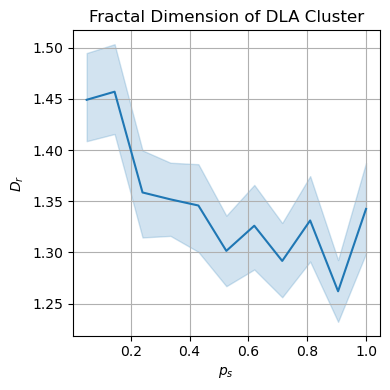

In [107]:
vis.plot_dla_mc_sim_params(df_sim_results)

The plot indicates a decrease in $D_r$ with larger $p_s$ values, similar to the effect of increasing $\eta$ in the model based on the diffusion equation, albeit in a less linear relationship. This can be explained by the compactification of the cluster for small $p_s$ values, logically resulting from the lower acceptance of adjacent walkers at the cluster tips and the trajectories entering deeper into the intermediate spaces between the branches. On the other hand, large $p_s$ yields immediate attachment of incoming walkers and therefore a less dense growth at the tips. It is thereby noticeable that, when using $p_s$ as a control parameter, the range of achievable fractal dimensions is much more narrow than with the previous model. The following series of plots are illustrative of the different morphologies emerging at varying values of $p_s$.

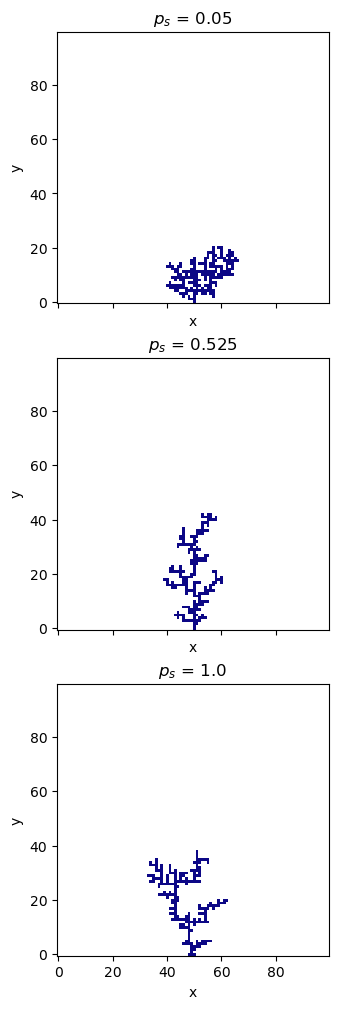

In [125]:
p_s_plot = [0.05, 0.525, 1.0]

# Get index of first simulations in DataFrame for each eta
p_s_indices = [df_sim_results[df_sim_results['$p_s$'] == p_s].index[0] for p_s in p_s_plot]
cluster_grids_plot = cluster_grids.reshape(-1, cluster_grids.shape[-2], cluster_grids.shape[-1])[p_s_indices]

vis.plot_dla_param_snapshots(cluster_grids_plot, p_s_plot, param_name="$p_s$")

## 3. Gray-Scott Reaction-Diffusion Model

The Gray-Scott reaction-diffusion model represents the spatio-temporal interaction of two chemical components $U$ and $V$ and is based on the following PDEs:

$$
\frac{\partial{u}}{\partial{t}} = D_u\nabla^2{u} - uv^2 + f(1-u),\tag{1}
$$

$$
\frac{\partial{v}}{\partial{t}} = D_v\nabla^2{v} + uv^2 - (f+k)v,\tag{2}
$$

where $u$ and $v$ represent the concentrations of the two substances. These equations contain terms characteristic for every reaction-diffusion system:
- a diffusion term ($D_u\nabla^2{u}$ and $D_v\nabla^2{v}$) responsible for the spreading of concentrations in space, $D_u$ and $D_v$ being the respective diffusion rates;
- a reaction term $uv^2$ yielding a concentration-proportional transformation of the $U$ into $V$ as a result of the law of mass action;
- a feed/decay term representing the addition or removal of chemical concentrations to and from the system.

The first step in implementing the model is the derivation of an update scheme from the governing equations. With $u(t,x,y)$ expressing the concentration as a function of the time $t$ and the two spatial coordinates $x$ and $y$, a finite-difference discretisation of the left-hand terms yields:

$$
\frac{\partial{u}}{\partial{t}} = \frac{u(t+\delta,x,y)-u(t,x,y)}{\delta{t}}\tag{3}
$$

and

$$
\frac{\partial{v}}{\partial{t}} = \frac{v(t+\delta,x,y)-v(t,x,y)}{\delta{t}}.\tag{4}
$$

Similarly, the diffusion terms can be expressed as:

$$
\nabla^2{u(t,x,y)} = \frac{u(t,x+\delta{x},y)+u(t,x-\delta{x},y)+u(t,x,y+\delta{y})+u(t,x,y-\delta{y})-4u(t,x,y)}{\delta{x}^2}=L_u\tag{5}
$$

and

$$
\nabla^2{v(t,x,y)} = \frac{v(t,x+\delta{x},y)+v(t,x-\delta{x},y)+v(t,x,y+\delta{y})+v(t,x,y-\delta{y})-4v(t,x,y)}{\delta{x}^2}=L_v,\tag{6}
$$

under the consideration that $\delta{x}\equiv\delta{y}$. Equations 3-6 can then be substituted in Equation 1 and 2, followed by a rearrangement of the terms:

$$
u(t+\delta,x,y)=u(t,x,y)+\delta{t}\left[D_uL_u-u(t,x,y)v(t,x,y)^2+f(1-u(t,x,y))\right]
$$

$$
v(t+\delta,x,y)=v(t,x,y)+\delta{t}\left[D_vL_v+u(t,x,y)v(t,x,y)^2-(f+k)v(t,x,y)\right].
$$

These two expressions define the update scheme of the Gray-Scott model.

### 3.1. Model Test

The model is implemented on a square lattice of size $N\times N$, using a periodic boundary in each dimension. To test the implementation, $N$ is set to 100 and the time-dependent update scheme is run up to $t_{max}=10000$ using GPU parallelisation. The simulation is using the parameters $\delta{t}=1$, $\delta{x}=1$, $D_u=0.16$, $D_v=0.08$, $f=0.035$ and $k=0.060$. Two initial conditions are tested. The first one has a homogeneous concentration $u=0.5$ everywhere on the lattice, while $v$ is set to $0.25$ on a centered square with side length $N/4$ and to zero otherwise. The second one takes the same initial concentrations as the first one, but adds noise to $u$ from a uniform random distribution within the interval $[0, 0.001]$.

In [58]:
# Simulation parameters
size = 100
max_time = 10000
dt = 1
dx = 1
Du = 0.16
Dv = 0.08
f = 0.035
k = 0.06

# Initial conditions
square_size = size * 0.5
u0_a = np.full((size, size), 0.5)
u0_b = u0_a + np.random.uniform(0, 0.001, size=(size, size))
v0 = np.where(np.abs(np.arange(size) - (size-1) * 0.5) <= square_size * 0.5, 0.5, 0).reshape(size, 1)
v0 = v0 @ v0.T

# Run simulations
u_a, v_a = gs.run_gray_scott(u0_a, v0, max_time, Du, Dv, f, k, dt, dx)
u_b, v_b = gs.run_gray_scott(u0_b, v0, max_time, Du, Dv, f, k, dt, dx)

As the emerging patterns of $u$ and $v$ are very similar, it is sufficient to plot only one of the compounds. The plots below show the concentrations of $U$ at $t=10000$

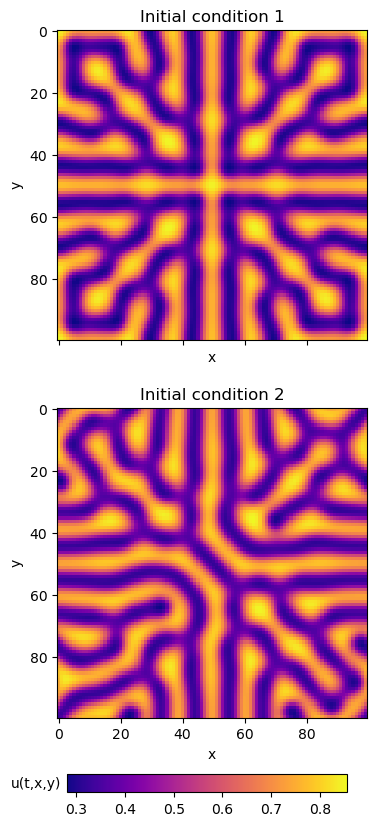

In [59]:
u_all = np.array([u_a, u_b])
vis.plot_reaction_diffusion(u_all, labels=['Initial condition 1', 'Initial condition 2'])

While the well-defined symmetrical initial condition yields a similarly symmetrical pattern of concentrations, a small perturbation of the initial condition due to noise can break this symmetry.

### 3.2. Parameter Exploration

A common way to explore the influence of the parameters $f$ and $k$ on the emergent patterns is by defining a two-dimensional gradient of locally specific parameter values, corresponding to the size of the concentration lattice. With $k$ increasing increasing linearly from $0$ to $0.08$ along the $x$-axis and $f$ doing so within the same interval along the $y$-axis, the system is set up on a lattice of size $N=1024$, with all initial $u$ concentrations set to $0.5$ and the initial $v$ concentrations set to uniform random values between $0$ and $1$. The simulation is run until $t_{max}=1000$ using the same remaining parameters as before.

Thanks to the use of vectorised _NumPy_ operations, the $k$ and $f$ input parameters can easily be replaced by arrays of values.

In [91]:
# Simulation parameters
size = 1024
max_time = 1000
dt = 1
dx = 1
Du = 0.16
Dv = 0.08
f = np.linspace(0, 0.08, size)
k = np.linspace(0, 0.08, size)
k_grid, f_grid = np.meshgrid(k, f)

# Initial conditions
square_size = size * 0.5
u0 = np.full((size, size), 0.5)
v0 = np.random.uniform(0, 1, size=(size, size))

# Run simulations
u, v = gs.run_gray_scott(u0, v0, max_time, Du, Dv, f_grid, k_grid, dt, dx)

In [89]:
reload(vis)

<module 'vis_tools' from 'd:\\GitHub\\scented-candles\\Assignment Set 2\\vis_tools.py'>

(11,)


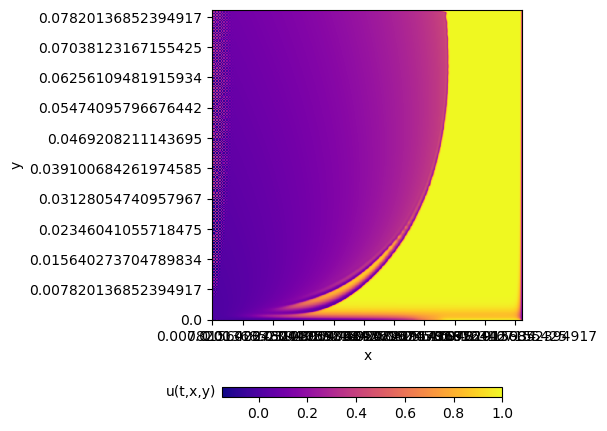

In [92]:
vis.plot_gray_scott_f_k(u, f, k)